<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Iguazio Feature Store and Model Serving

##### Create feature engineering pipeline
##### Deploy real-time feature ingestion service
##### Build model server and test it locally
##### Deploy model server to the cluster
##### Accessing features online and offline
 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

![](./feature_store_demo_diagram.png)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Initialize your project

In [2]:
import mlrun

project = mlrun.get_or_create_project("fraud", context="./", user_project=True)

> 2022-05-05 12:50:03,109 [info] loaded project fraud from MLRun DB


In [3]:

# Helper functions to adjust the timestamps of our data
# while keeping the order of the selected events and
# the relative distance from one event to the other

def date_adjustment(sample, data_max, new_max, old_data_period, new_data_period):
    '''
        Adjust a specific sample's date according to the original and new time periods
    '''
    sample_dates_scale = ((data_max - sample) / old_data_period)
    sample_delta = new_data_period * sample_dates_scale
    new_sample_ts = new_max - sample_delta
    return new_sample_ts

def adjust_data_timespan(dataframe, timestamp_col='timestamp', new_period='2d', new_max_date_str='now'):
    '''
        Adjust the dataframe timestamps to the new time period
    '''
    # Calculate old time period
    data_min = dataframe.timestamp.min()
    data_max = dataframe.timestamp.max()
    old_data_period = data_max-data_min
    
    # Set new time period
    new_time_period = pd.Timedelta(new_period)
    new_max = pd.Timestamp(new_max_date_str)
    new_min = new_max-new_time_period
    new_data_period = new_max-new_min
    
    # Apply the timestamp change
    df = dataframe.copy()
    df[timestamp_col] = df[timestamp_col].apply(lambda x: date_adjustment(x, data_max, new_max, old_data_period, new_data_period))
    return df

In [4]:

import pandas as pd

# Fetch the transactions dataset from the server
transactions_data = pd.read_csv('https://s3.wasabisys.com/iguazio/data/fraud-demo-mlrun-fs-docs/data.csv', parse_dates=['timestamp'])

# Adjust the samples timestamp for the past 2 days
transactions_data = adjust_data_timespan(transactions_data.sample(50000), new_period='2d')

# Preview
transactions_data.head(3)

,step,age,gender,zipcodeOri,zipMerchant,category,amount,fraud,timestamp,source,target,device
246253,82,5,F,28007,28007,es_transportation,40.40,0,2022-05-03 13:13:28.089315468,C2016890783,M348934600,fa8268e3cd464a46afba307f09927537
374125,119,2,F,28007,28007,es_transportation,18.01,0,2022-05-04 00:31:47.927948872,C1122835446,M1823072687,f48177e64b7f48e88b366540cdb1d858
421609,133,2,M,28007,28007,es_transportation,29.60,0,2022-05-04 11:06:59.627241095,C635603510,M348934600,ef522fd19085462cade324a7f4c0cf23


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Build a Feature Engineering Pipeline

### Feature Engineering: Define a Feature Set

In [5]:
# Import MLRun's Feature Store
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import OneHotEncoder, MapValues, DateExtractor

# Define the transactions FeatureSet
transaction_set = fstore.FeatureSet("transactions", 
                                 entities=[fstore.Entity("source")], 
                                 timestamp_key='timestamp', 
                                 description="transactions feature set")

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Feature Engineering: Add data transformations

In [6]:
# Define and add value mapping
main_categories = ["es_transportation", "es_health", "es_otherservices",
       "es_food", "es_hotelservices", "es_barsandrestaurants",
       "es_tech", "es_sportsandtoys", "es_wellnessandbeauty",
       "es_hyper", "es_fashion", "es_home", "es_contents",
       "es_travel", "es_leisure"]

# One Hot Encode the newly defined mappings
one_hot_encoder_mapping = {'category': main_categories,
                           'gender': list(transactions_data.gender.unique())}

# Define the graph steps
transaction_set.graph\
    .to(DateExtractor(parts = ['hour', 'day_of_week'], timestamp_col = 'timestamp'))\
    .to(MapValues(mapping={'age': {'U': '0'}}, with_original_features=True))\
    .to(OneHotEncoder(mapping=one_hot_encoder_mapping))
    

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Feature Engineering: Add aggregations

In [7]:
# Add aggregations for 2, 12, and 24 hour time windows
transaction_set.add_aggregation(name='amount',
                                column='amount',
                                operations=['avg', 'sum', 'count', 'max'],
                                windows=['2h', '12h', '24h'],
                                period='1h')

# Add the category aggregations over a 14 day window
for category in main_categories:
    transaction_set.add_aggregation(name=category,column=f'category_{category}',
                                    operations=['count'], windows=['14d'], period='1d')

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Feature Engineering: Set targets

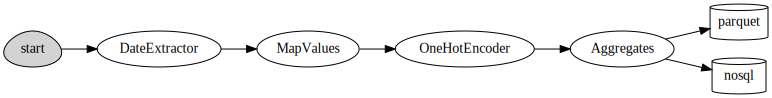

In [33]:
# Add default (offline-parquet & online-nosql) targets
transaction_set.set_targets()

# Plot the pipeline so we can see the different steps
transaction_set.plot(rankdir="LR", with_targets=True)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Create feature ingestion service

In [35]:
# Create iguazio v3io stream and transactions push API endpoint
transaction_stream = f'v3io:///projects/{project.name}/streams/transaction'
transaction_pusher = mlrun.datastore.get_stream_pusher(transaction_stream)

# Define the source stream trigger (use v3io streams)
source = mlrun.datastore.sources.StreamSource(path=transaction_stream , key_field='source', time_field='timestamp')

# Deploy the transactions feature set's ingestion service over a real-time (Nuclio) serverless function
transaction_set_endpoint = fstore.deploy_ingestion_service(featureset=transaction_set, source=source)

> 2022-04-11 19:50:58,438 [info] Starting remote function deploy
2022-04-11 23:50:58  (info) Deploying function
2022-04-11 23:50:58  (info) Building
2022-04-11 23:50:58  (info) Staging files and preparing base images
2022-04-11 23:50:58  (info) Building processor image
2022-04-11 23:51:00  (info) Build complete
2022-04-11 23:51:05  (info) Function deploy complete
> 2022-04-11 19:51:06,988 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-brennan-transactions-ingest.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-brennan-transactions-ingest-fraud-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com/']}


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Test the feature ingestion service

In [36]:
import requests
import json

# Select a sample from the dataset and serialize it to JSON
transaction_sample = json.loads(transactions_data.sample(1).to_json(orient='records'))[0]
transaction_sample['timestamp'] = str(pd.Timestamp.now())
transaction_sample

{'step': 90,
 'age': '1',
 'gender': 'M',
 'zipcodeOri': 28007,
 'zipMerchant': 28007,
 'category': 'es_transportation',
 'amount': 36.33,
 'fraud': 0,
 'timestamp': '2022-04-11 19:51:17.540333',
 'source': 'C759264122',
 'target': 'M348934600',
 'device': 'acdc34e868bf40d5953dc5291658bb92'}

In [37]:
# Post the sample to the ingestion endpoint
requests.post(transaction_set_endpoint, json=transaction_sample).text

'{"id": "9cbca32c-9c6b-414b-9d94-40ee69bda6b4"}'

In [53]:
#mlrun: start-code

In [54]:
import numpy as np
from cloudpickle import load
from mlrun.serving.v2_serving import V2ModelServer

class ClassifierModel(V2ModelServer):
    
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))
        
    def predict(self, body: dict) -> list:
        """Generate model predictions from sample"""
        print(f"Input -> {body['inputs']}")
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [55]:
#mlrun: end-code

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Build the model server

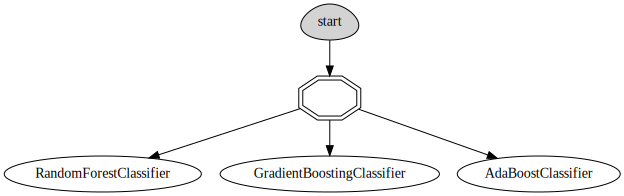

In [58]:
serving_fn = mlrun.code_to_function('transaction-fraud', kind='serving', image="mlrun/mlrun", filename="fraud.ipynb")

serving_fn.set_topology('router', 'mlrun.serving.routers.EnrichmentVotingEnsemble', name='VotingEnsemble',
                        feature_vector_uri="transactions-fraud-short", impute_policy={"*": "$mean"})

model_names = [
'RandomForestClassifier',
'GradientBoostingClassifier',
'AdaBoostClassifier'
]

for i, name in enumerate(model_names, start=1):
    serving_fn.add_model(name, class_name="ClassifierModel", 
                               model_path=project.get_artifact_uri(f"training_model#{i}:latest"))

# Plot the ensemble configuration
serving_fn.spec.graph.plot()

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Locally test your model server

In [68]:
local_server = serving_fn.to_mock_server()

sample_id = 'C76780537'
model_inference_path = '/v2/models/infer'

# Send our sample ID for prediction
local_server.test(path=model_inference_path,
            body={'inputs': [[sample_id]]})

> 2022-04-12 10:57:23,655 [info] model RandomForestClassifier was loaded
> 2022-04-12 10:57:24,042 [info] model GradientBoostingClassifier was loaded
> 2022-04-12 10:57:24,345 [info] model AdaBoostClassifier was loaded
Input -> [[43.654233654034954, 0.0, 0.0, 43.11027520412492, 56.11269271549185]]Input -> [[43.654233654034954, 0.0, 0.0, 43.11027520412492, 56.11269271549185]]

Input -> [[43.654233654034954, 0.0, 0.0, 43.11027520412492, 56.11269271549185]]


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
X does not have valid feature names, but AdaBoostClassifier was fitted with feature names


{'id': 'd38c1edfc7164735bcb0cfc9319155fe',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<a id="deploy"></a>
## Deploy the model server to the cluster

In [59]:
serving_fn.deploy()

> 2022-04-11 21:01:52,424 [info] Starting remote function deploy
2022-04-12 01:01:52  (info) Deploying function
2022-04-12 01:01:52  (info) Building
2022-04-12 01:01:52  (info) Staging files and preparing base images
2022-04-12 01:01:52  (info) Building processor image
2022-04-12 01:01:56  (info) Build complete
2022-04-12 01:05:04  (info) Function deploy complete
> 2022-04-11 21:05:05,350 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-fraud-brennan-transaction-fraud.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['fraud-brennan-transaction-fraud-fraud-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com/']}


'http://fraud-brennan-transaction-fraud-fraud-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com/'

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<a id="live_model_test"></a>
## Programmatically test live model

In [60]:
sample_id = 'C76780537'
model_inference_path = '/v2/models/infer'

# Send our sample ID for prediction
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2022-04-11 21:11:13,313 [info] invoking function: {'method': 'POST', 'path': 'http://fraud-brennan-transaction-fraud-fraud-brennan.default-tenant.app.us-sales-322.iguazio-cd1.com//v2/models/infer'}


{'id': '28a74877-3d2c-4653-af23-ef6731210db7',
 'model_name': 'VotingEnsemble',
 'outputs': [0],
 'model_version': 'v1'}

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Get features online

In [62]:
# Create the online feature service
svc = fstore.get_online_feature_service('transactions-fraud-short:latest', impute_policy={"*": "$mean"})

# Get sample feature vector
sample_fv = svc.get([{'source': sample_id}])
sample_fv

[{'amount_max_2h': 43.654233654034954,
  'amount_max_12h': 120.73,
  'amount_sum_2h': 0.0,
  'amount_count_2h': 0.0,
  'amount_avg_2h': 43.11027520412492}]

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Get features offline

In [64]:
# Import the Parquet Target so we can directly save our dataset as a file
from mlrun.datastore.targets import ParquetTarget

# Get offline feature vector as dataframe and save the dataset to parquet
train_dataset = fstore.get_offline_features('transactions-fraud', target=ParquetTarget())

> 2022-04-11 21:17:02,346 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fraud-brennan/FeatureStore/transactions-fraud/parquet/vectors/transactions-fraud-latest.parquet', 'status': 'ready', 'updated': '2022-04-12T01:17:02.346373+00:00', 'size': 1617693}


In [66]:
train_dataset.to_dataframe().tail(5)

,amount_max_2h,amount_sum_2h,amount_count_2h,amount_avg_2h,amount_max_12h,amount_sum_12h,amount_count_12h,amount_avg_12h,amount_max_24h,amount_sum_24h,...,gender_F,gender_M,step,amount,timestamp_hour,timestamp_day_of_week,event_details_change,event_login,event_password_change,label
49995,20.42,20.42,1.0,20.420,34.16,81.85,4.0,20.4625,34.16,81.85,...,1,0,135,20.42,22,0,0.0,1.0,0.0,0
49996,21.18,27.47,2.0,13.735,40.27,95.48,4.0,23.8700,40.27,95.48,...,0,1,101,6.29,22,0,0.0,0.0,1.0,0
49997,51.94,51.94,1.0,51.940,51.94,51.94,1.0,51.9400,51.94,51.94,...,1,0,8,51.94,22,0,1.0,0.0,0.0,0
49998,35.67,35.67,1.0,35.670,35.67,35.67,1.0,35.6700,35.67,44.50,...,1,0,30,35.67,22,0,0.0,0.0,1.0,0
49999,38.10,38.10,1.0,38.100,61.48,99.58,2.0,49.7900,61.48,176.11,...,0,1,65,38.10,22,0,0.0,0.0,1.0,0


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

![](./feature_store_demo_diagram.png)